In [706]:
'''
1st project after my 1st Python course.
Includes:
    Exploratory Data Analysis (EDA)
    Feature Engineering
    Testing of different machine learning methods
    Models improving via feature and parameters selection
    Attempts on model ensambling '''

'\n1st project after my 1st Python course.\nIncludes:\n    Exploratory Data Analysis (EDA)\n    Feature Engineering\n    Testing of different machine learning methods\n    Models improving via feature and parameters selection\n    Attempts on model ensambling '

In [707]:
### LIBRARIES ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score#, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder#, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [708]:
## DATASETS ##

PATH_train = "/Users/villela/Documents/01_PyML_challenges/titanic/train.csv"
PATH_test = "/Users/villela/Documents/01_PyML_challenges/titanic/test.csv"

In [709]:
## CREATE DATAFRAMES FROM DATASETS ##

df = pd.read_csv(PATH_train)
df_test = pd.read_csv(PATH_test)

In [710]:
### UNDERSTANDING THE DATAFRAME ###

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [711]:
### AMOUNT OF ENTRIES AND DATA TYPES ###

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [712]:
### IDENTIFYING MISSING VALUES ###

df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [713]:
# THERE ARE 177 MISSING VALUES AT 'Age'
# WHEN I DON'T HAVE AGE, I MAY BE ABLE TO IDENTIFY ADULTS VS CHILDREN USING TITLES

In [714]:
### EXTRACT TITLE FROM NAME ###

def extract_title(name):
    titles = ['Miss.', 'Mrs.', 'Ms.', 'Mr.', 'Master.', 'Rev.', 'Don.', 'Dr.', 'Mme.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'Countess.', 'Jonkheer.']
    for title in titles:
        if title in name:
            return title[:-1]  # Remove the trailing dot
    return 'Other'

df['Title'] = df['Name'].apply(extract_title)

df_dummies = pd.get_dummies(df['Title'], prefix='Title')
df = pd.concat([df, df_dummies], axis=1)

label_encoder = LabelEncoder()
df['Sex_encoded'] = label_encoder.fit_transform(df['Sex'])

df.rename(columns={'Sex_encoded': 'Sex [M=1, F=0]'}, inplace=True)

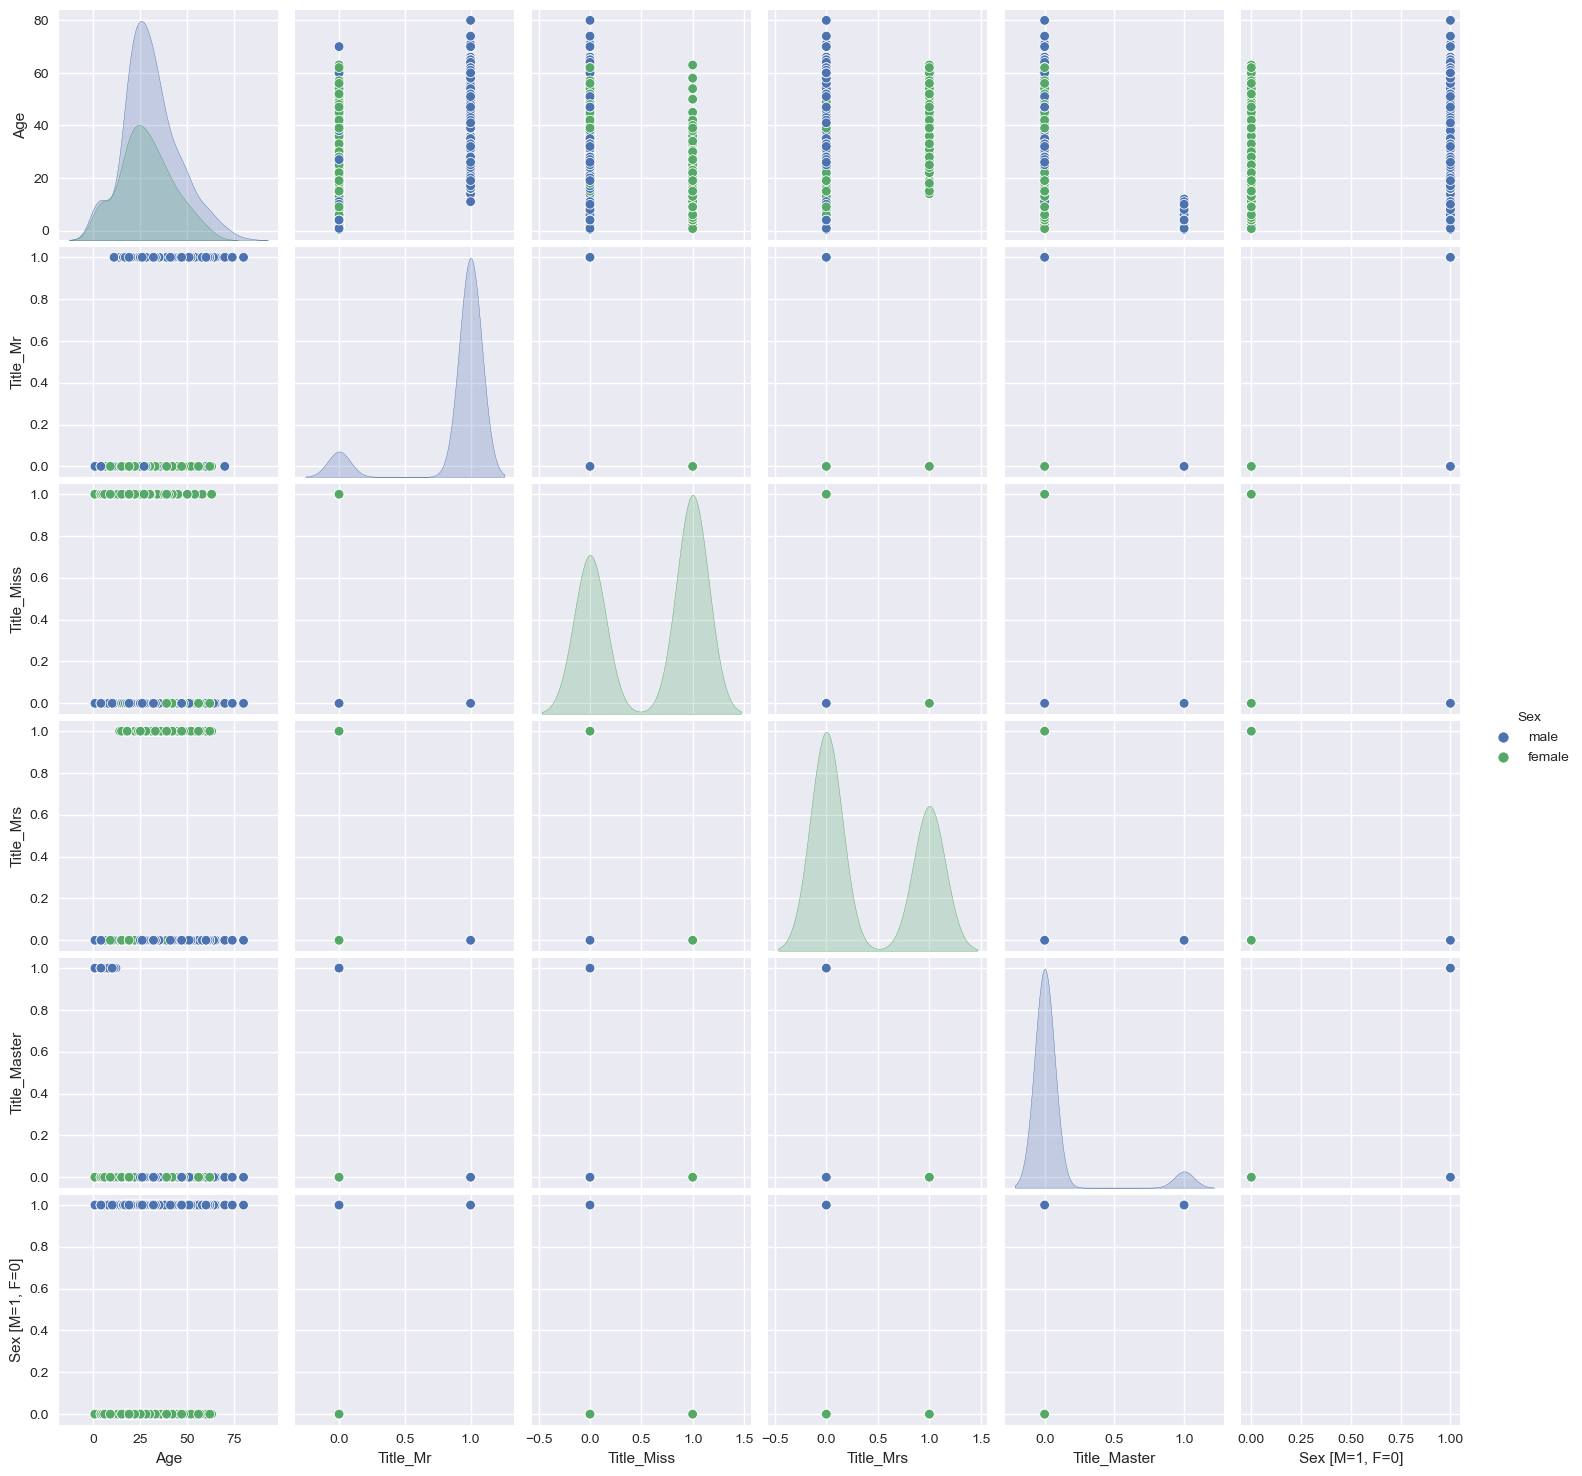

In [715]:
### EVALUATE CONSISTENCY BETWEEN TITLE AND AGE ###

# sns.pairplot(df[['Sex', 'Age', 'Title_Mr', 'Sex [M=1, F=0]']],hue='Sex')

sns.pairplot(df[['Sex', 'Age', 'Title_Mr', 'Title_Miss', 'Title_Mrs',
       'Title_Master', 'Sex [M=1, F=0]']],hue='Sex')

In [730]:
# SO IT SEEMS THAT:
#     TITLE 'MR' MEANS MALE ADULT
#     TITLE 'MASTER' MEANS MALE CHILDREN
#     TITLE 'MISS' IS INCONCLUSIVE
#     TITLE 'MRS' IS ADULT FEMALE

print(f"'Mr.' min age is {int(df[df['Title_Mr'] == 1]['Age'].min())} and avg is {int(df[df['Title_Mr'] == 1]['Age'].mean())}")
print(f"'Master.' max age is {int(df[df['Title_Master'] == 1]['Age'].max())} and avg is {int(df[df['Title_Master'] == 1]['Age'].mean())}")
print(f"'Miss.' min age is {int(df[df['Title_Miss'] == 1]['Age'].min())} and max is {int(df[df['Title_Miss'] == 1]['Age'].max())}")
print(f"'Mrs.' min age is {int(df[df['Title_Mrs'] == 1]['Age'].min())} and avg is {int(df[df['Title_Mrs'] == 1]['Age'].mean())}")

'Mr.' min age is 11 and avg is 32
'Master.' max age is 12 and avg is 4
'Miss.' min age is 0 and max is 63
'Mrs.' min age is 14 and avg is 35


In [731]:
### AGE_RANGE COLUMN ###
# I assumed it was more important to determine if
# the passanger was a child or an adult than to
# actually knowing the age of the passenger.
# If I were to do it again, I'd try a ML model
# to predict 'Age' based on other available features.

def determine_age_range(row):
    if not np.isnan(row['Age']):
        if row['Age'] < 13:
            return 'Child'
        elif row['Age'] < 60:
            return 'Adult'
        else:
            return 'Senior'
    else:
        if row['Title'] in ['Master']:
            return 'Child'
        elif row['Title'] in ['Mr', 'Mrs']:
            return 'Adult'
        else:
            return 'Unknown'

df['Age_Range'] = df.apply(determine_age_range, axis=1)
df_dummies = pd.get_dummies(df['Age_Range'], prefix='Age_Range')
df = pd.concat([df, df_dummies], axis=1)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Title_Capt',
       'Title_Col', 'Title_Countess', 'Title_Don', 'Title_Dr',
       'Title_Jonkheer', 'Title_Lady', 'Title_Major', 'Title_Master',
       'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr', 'Title_Mrs',
       'Title_Ms', 'Title_Rev', 'Title_Sir', 'Sex [M=1, F=0]', 'Age_Range',
       'Age_Range_Adult', 'Age_Range_Child', 'Age_Range_Senior',
       'Age_Range_Unknown'],
      dtype='object')

In [737]:
### FIRST EVALUATION OF PREDICTION MODELS ###
# Using random state 42 to enable comparison with different features and parameters
# At this stage, choice of features (X columns) was done intuitively

X = df[['Pclass', 'Parch', 'Fare', 'Sex [M=1, F=0]',
       'Age_Range_Adult', 'Age_Range_Child', 'Age_Range_Senior']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

models = (
    ('Logistic', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('DecTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('Gradient Boost Classifier', GradientBoostingClassifier(random_state=42))
)

for model_name, model in models:
    model.fit(X_train, y_train)
    print(model_name, model.score(X_test, y_test))

Logistic 0.7932960893854749
KNN 0.8044692737430168
DecTree 0.8379888268156425
RandomForest 0.8547486033519553
Gradient Boost Classifier 0.8324022346368715


In [738]:
### AGE-SEX FEATURE ###
# So far, I had 'Age_Range' feature and 'Sex' feature.
# Wanted to test if having a 'Age_Sex' (combined) feature would improve scores.

df['Male_Adult'] = df['Sex [M=1, F=0]'] * df['Age_Range_Adult']
df['Male_Child'] = df['Sex [M=1, F=0]'] * df['Age_Range_Child']
df['Male_Senior'] = df['Sex [M=1, F=0]'] * df['Age_Range_Senior']
df['Female_Adult'] = (df['Sex [M=1, F=0]'] == 0) * df['Age_Range_Adult']
df['Female_Child'] = (df['Sex [M=1, F=0]'] == 0) * df['Age_Range_Child']
df['Female_Senior'] = (df['Sex [M=1, F=0]'] == 0) * df['Age_Range_Senior']

X = df[['Pclass', 'Parch', 'Fare', 'Male_Adult', 'Male_Child',
        'Male_Senior', 'Female_Adult', 'Female_Child', 'Female_Senior']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

models = (
    ('Logistic', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('DecTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('Gradient Boost Classifier', GradientBoostingClassifier(random_state=42))
)

for model_name, model in models:
    model.fit(X_train, y_train)
    print(model_name, model.score(X_test, y_test))

Logistic 0.776536312849162
KNN 0.8268156424581006
DecTree 0.8379888268156425
RandomForest 0.8491620111731844
Gradient Boost Classifier 0.8491620111731844


In [ ]:
### COMPARISONS SO FAR ###

# Age_Range features and Sex features
    # Logistic 0.7932960893854749
    # KNN 0.8044692737430168
    # DecTree 0.8379888268156425
    # RandomForest 0.8547486033519553                <----- best score so far .8547
    # Gradient Boost Classifier 0.8324022346368715

# Age_Sex combined features
    # Logistic 0.776536312849162
    # KNN 0.8268156424581006
    # DecTree 0.8379888268156425
    # RandomForest 0.8491620111731844                <----- best score at this attempt .8492
    # Gradient Boost Classifier 0.8491620111731844   <----- best score at this attempt .8492
    
# DecTree, RandomForest and GradientBoost outperforming Logistic and KNN from the start
# No meaningful difference between features at this stage

In [739]:
# Testing using both the separate (age_range and sex) and combined (age_sex) features.

X = df[['Pclass', 'Parch', 'Fare', 'Male_Adult', 'Male_Child',
        'Male_Senior', 'Female_Adult', 'Female_Child', 'Female_Senior', 'Sex [M=1, F=0]']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

models = (
    ('Logistic', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('DecTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('Gradient Boost Classifier', GradientBoostingClassifier(random_state=42))
)

for model_name, model in models:
    model.fit(X_train, y_train)
    print(model_name, model.score(X_test, y_test))

Logistic 0.8100558659217877
KNN 0.8268156424581006
DecTree 0.8379888268156425
RandomForest 0.8547486033519553
Gradient Boost Classifier 0.8324022346368715


In [740]:
# No significant differences to scores so far.

In [742]:
### ALONE FEATURE ###
# Rather than using SibSp or Parch, maybe the
# information of if the passanger was alone or not is more relevant.

df['Alone'] = df.apply(lambda row: 1 if row['SibSp'] + row['Parch'] > 0 else 0, axis=1)

In [743]:
X = df[['Pclass', 'Parch', 'Fare', 'Sex [M=1, F=0]', 'Alone',
       'Age_Range_Adult', 'Age_Range_Child', 'Age_Range_Senior']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

models = (
    ('Logistic', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('DecTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('Gradient Boost Classifier', GradientBoostingClassifier(random_state=42))
)

for model_name, model in models:
    model.fit(X_train, y_train)
    print(model_name, model.score(X_test, y_test))

Logistic 0.7932960893854749
KNN 0.8100558659217877
DecTree 0.8324022346368715
RandomForest 0.8379888268156425
Gradient Boost Classifier 0.8324022346368715


In [744]:
# Scores did not improve with the 'Alone' feature.

In [745]:
### DECK AND CABIN POSITION FEATURES ###
# Here the hypothesis is that Deck and Cabin position (based on cabin n#)
# were relevant to survival, based on proximity to life-boats deck.

df['Cabin'].fillna('unknown', inplace=True)
df['Deck'] = df.apply(lambda row: 'unknown' if row['Cabin'] == 'unknown' else row['Cabin'][0:1], axis=1)
df['Cabin #'] = df.apply(lambda row: 'unknown' if (row['Cabin'] == 'unknown') or (not row['Cabin'].split(' ')[0][1:].isdigit()) else int(row['Cabin'].split(' ')[0][1:]), axis=1)

/var/folders/j4/48d_zp914zjcvl7wg8l5qsqh0000gn/T/ipykernel_9135/3866692899.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Cabin #'] = df_filtered['Cabin #'].astype(int)


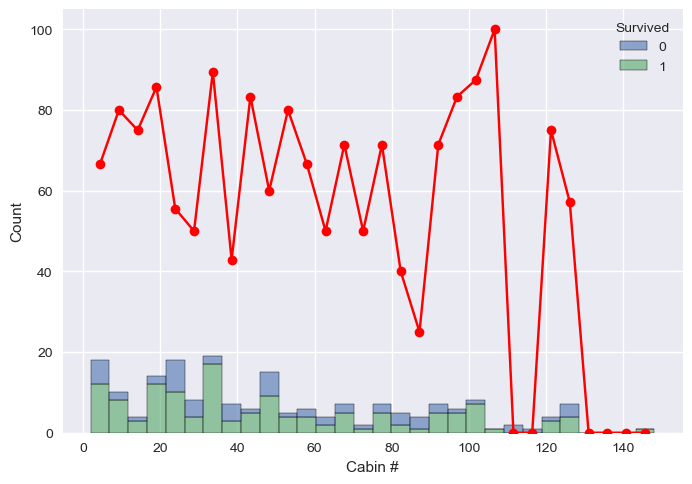

In [746]:
### PLOTTING SURVIVAL RATE BASED ON CABIN N#, WHEN KNOWN ###

n_bins = 31

# Filter out 'unknown' values first and convert the 'Cabin #' column to integers
df_filtered = df[df['Cabin #'] != 'unknown']
df_filtered['Cabin #'] = df_filtered['Cabin #'].astype(int)

bin_edges = np.linspace(df_filtered['Cabin #'].min(), df_filtered['Cabin #'].max(), n_bins)
sns.histplot(df_filtered, x='Cabin #', hue='Survived', multiple='stack', bins=bin_edges, alpha=0.6)
bin_labels = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges) - 1)]
survival_rate = []

for i in range(len(bin_edges) - 1):
    subset = df_filtered[(df_filtered['Cabin #'] >= bin_edges[i]) & (df_filtered['Cabin #'] < bin_edges[i+1])]
    survival_rate.append(subset['Survived'].mean() if not subset.empty else 0)

plt.plot(bin_labels, np.array(survival_rate) * 100, marker='o', color='r', label='Survival Rate (%)')

In [747]:
print(f"Survival rate when Cabin # is known: {round(df[df['Cabin #'] != 'unknown']['Survived'].mean(),2)}")
print(f"Survival rate when Cabin # is unknown: {round(df[df['Cabin #'] == 'unknown']['Survived'].mean(),2)}")

Survival rate when Cabin # is known: 0.68
Survival rate when Cabin # is unknown: 0.3


In [333]:
# Based on the plotted chart, there is no clear relationship between
# cabin n# (when known) and survival rate. There is a peak between #95-110,
# and a valley around #85, but does not appear significant for the model.

# Nevertheless, there is a significant difference in survival rate between
# passengers where cabin n# is known vs passengers where this data is missing.
# Perhaps, the availability of this data is skewed towards survivers, as they
# might have remembered and provided this information after the accident.

/var/folders/j4/48d_zp914zjcvl7wg8l5qsqh0000gn/T/ipykernel_9135/372570814.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Deck_enc'] = df_filtered['Deck_enc'].astype(int)


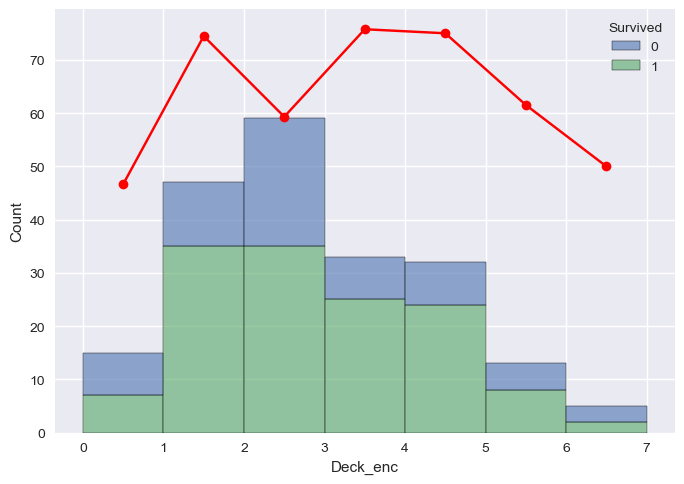

In [748]:
### PLOTTING SURVIVAL RATE BASED ON DECK, WHEN KNOWN ###

label_encoder = LabelEncoder()
df['Deck_enc'] = label_encoder.fit_transform(df['Deck'])
df[['Deck', 'Deck_enc']].head()

n_bins = 8

# Filter out 'unknown' values first and convert the 'Cabin #' column to integers
df_filtered = df[df['Deck'] != 'unknown']
df_filtered['Deck_enc'] = df_filtered['Deck_enc'].astype(int)

# Define the bin edges
bin_edges = np.linspace(df_filtered['Deck_enc'].min(), df_filtered['Deck_enc'].max(), n_bins)

# Create the histogram
sns.histplot(df_filtered, x='Deck_enc', hue='Survived', multiple='stack', bins=bin_edges, alpha=0.6)

# Calculate the average survival rate for each bin
bin_labels = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges) - 1)]
survival_rate = []

for i in range(len(bin_edges) - 1):
    subset = df_filtered[(df_filtered['Deck_enc'] >= bin_edges[i]) & (df_filtered['Deck_enc'] < bin_edges[i+1])]
    survival_rate.append(subset['Survived'].mean() if not subset.empty else 0)

# Create the line chart for survival rate
plt.plot(bin_labels, np.array(survival_rate) * 100, marker='o', color='r', label='Survival Rate (%)')

/var/folders/j4/48d_zp914zjcvl7wg8l5qsqh0000gn/T/ipykernel_9135/3750137301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Deck_enc'] = df_filtered['Deck_enc'].astype(int)


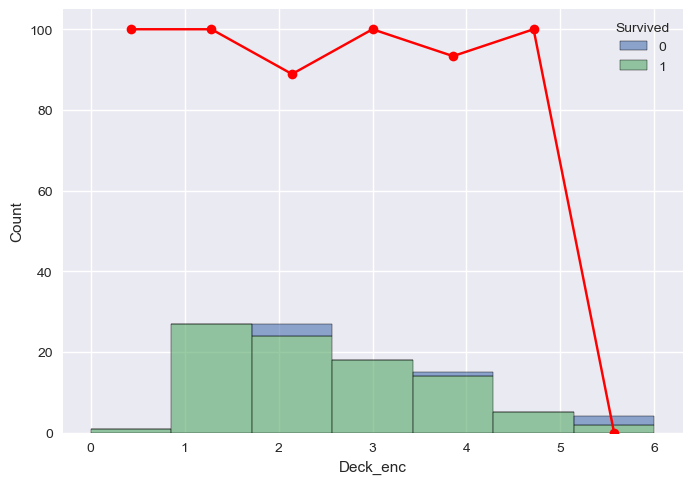

In [749]:
### PLOTTING SURVIVAL RATE BASED ON DECK, WHEN KNOWN, FOR FEMALES ONLY ###

n_bins = 8

# Filter out 'unknown' values first and convert the 'Cabin #' column to integers
df_filtered = df[(df['Deck'] != 'unknown') & (df['Sex'] == 'female')]
df_filtered['Deck_enc'] = df_filtered['Deck_enc'].astype(int)

# Define the bin edges
bin_edges = np.linspace(df_filtered['Deck_enc'].min(), df_filtered['Deck_enc'].max(), n_bins)

# Create the histogram
sns.histplot(df_filtered, x='Deck_enc', hue='Survived', multiple='stack', bins=bin_edges, alpha=0.6)

# Calculate the average survival rate for each bin
bin_labels = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges) - 1)]
survival_rate = []

for i in range(len(bin_edges) - 1):
    subset = df_filtered[(df_filtered['Deck_enc'] >= bin_edges[i]) & (df_filtered['Deck_enc'] < bin_edges[i+1])]
    survival_rate.append(subset['Survived'].mean() if not subset.empty else 0)

# Create the line chart for survival rate
plt.plot(bin_labels, np.array(survival_rate) * 100, marker='o', color='r', label='Survival Rate (%)')

In [ ]:
# *** COMMENT ON THE ABOVE ***

/var/folders/j4/48d_zp914zjcvl7wg8l5qsqh0000gn/T/ipykernel_9135/1060443715.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Known Starboard'] = df_filtered['Known Starboard'].astype(int)


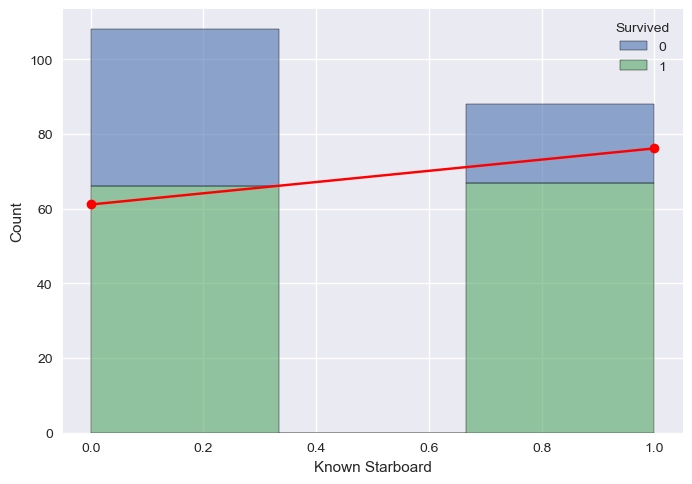

In [750]:
### PLOTTING SURVIVAL RATE BASED ON SIDE OF SHIP (STARBOARD VS PORT) ###

df['Starboard'] = df.apply(lambda row: 0 if row['Cabin #'] == 'unknown' else row['Cabin #']%2, axis=1)
df.rename(columns={'Starboard': 'Known Starboard'}, inplace=True)
df[['Cabin #', 'Known Starboard']]

# Filter out 'unknown' values first and convert the 'Cabin #' column to integers
df_filtered = df[df['Cabin #'] != 'unknown']
df_filtered['Known Starboard'] = df_filtered['Known Starboard'].astype(int)

# Create the histogram
sns.histplot(df_filtered, x='Known Starboard', hue='Survived', multiple='stack', bins=3, alpha=0.6)

# survival_rate.append(subset['Survived'].mean() if not subset.empty else 0)

# Create the line chart for survival rate
survival_rate = df_filtered.groupby('Known Starboard')['Survived'].mean().reset_index()
# plt.plot(bin_labels, np.array(survival_rate) * 100, marker='o', color='r', label='Survival Rate (%)')
plt.plot(survival_rate['Known Starboard'], survival_rate['Survived'] * 100, marker='o', color='r', label='Survival Rate (%)')

In [ ]:
# THERE IS SOME DIFFERENT IN SURVIVORS BASED ON THEM BEING ON STARBOARD VS PORT SIDE OF THE SHIP

In [759]:
### EVALUATE PREDICTIONS INCLUDING INFORMATION ON:
#     CABIN KNOWN VS UNKNOWN
#     DECK
#     PORT VS STARBOARD

df['Cabin Known'] = df['Cabin #'].apply(lambda x: 1 if x != 'unknown' else 0)

X = df[['Pclass', 'Parch', 'Fare', 'Sex [M=1, F=0]',
        'Age_Range_Adult', 'Age_Range_Child', 'Age_Range_Senior',
        'Deck_enc', 'Known Starboard', 'Cabin Known']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

models = (
    ('Logistic', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('DecTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('Gradient Boost Classifier', GradientBoostingClassifier(random_state=42))
)

for model_name, model in models:
    model.fit(X_train, y_train)
    print(model_name, model.score(X_test, y_test))

Logistic 0.7988826815642458
KNN 0.7653631284916201
DecTree 0.8156424581005587
RandomForest 0.8324022346368715
Gradient Boost Classifier 0.8324022346368715


In [760]:
# No improvement on scores.

In [777]:
# ATTEMPTS ON ENSAMBLE MODELS

X = df[['Pclass', 'Parch', 'Fare', 'Sex [M=1, F=0]',
       'Age_Range_Adult', 'Age_Range_Child', 'Age_Range_Senior']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = (
    ('Logistic', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('DecTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('Gradient Boost Classifier', GradientBoostingClassifier(random_state=42))
)

# Fit models and store them in a dictionary
model_dict = {}
for model_name, model in models:
    model.fit(X_train, y_train)
    model_dict[model_name] = model

# Initialize final predictions array
final_predictions = np.zeros(len(X_test))

# Get Random Forest predictions and certainty
rf_predictions, rf_certainty = model_dict['RandomForest'].predict(X_test), model_dict['RandomForest'].predict_proba(X_test)

# Keep high-certainty Random Forest predictions
high_certainty_rf = rf_certainty.max(axis=1) > 0.8
final_predictions[high_certainty_rf] = rf_predictions[high_certainty_rf]

# Update remaining_indices for Decision Tree
remaining_indices = ~high_certainty_rf

# Get Decision Tree predictions and certainty for remaining instances
dt_predictions, dt_certainty = model_dict['DecTree'].predict(X_test[remaining_indices]), model_dict['DecTree'].predict_proba(X_test[remaining_indices])

# Keep high-certainty Decision Tree predictions
high_certainty_dt = dt_certainty.max(axis=1) > 0.8
final_predictions[remaining_indices][high_certainty_dt] = dt_predictions[high_certainty_dt]

# Update remaining_indices for KNN
remaining_indices[remaining_indices] = ~high_certainty_dt

# Get KNN predictions and certainty for remaining instances
knn_predictions, knn_certainty = model_dict['KNN'].predict(X_test[remaining_indices]), model_dict['KNN'].predict_proba(X_test[remaining_indices])

# Keep high-certainty KNN predictions
high_certainty_knn = knn_certainty.max(axis=1) > 0.8
final_predictions[remaining_indices][high_certainty_knn] = knn_predictions[high_certainty_knn]

# Update remaining_indices for Logistic Regression
remaining_indices[remaining_indices] = ~high_certainty_knn

# Use Logistic Regression for the rest
log_reg_predictions = model_dict['Logistic'].predict(X_test[remaining_indices])
final_predictions[remaining_indices] = log_reg_predictions

# Create a DataFrame to store the results
df_score = pd.DataFrame()
df_score['actual'] = y_test
df_score['predictions'] = final_predictions.astype(int)
df_score['result'] = (df_score['actual'] == df_score['predictions']).astype(int)

# Calculate the mean score
mean_score = df_score['result'].mean()
print(f"Mean Score: {mean_score}")


Mean Score: 0.8324022346368715


In [767]:
# No improvement on scores.

In [788]:
# I'll try some regularization. These are the starting point scores.

X = df[['Pclass', 'Parch', 'Fare', 'Male_Adult', 'Male_Child',
        'Male_Senior', 'Female_Adult', 'Female_Child', 'Female_Senior', 'Sex [M=1, F=0]',
        'Age_Range_Adult', 'Age_Range_Child', 'Age_Range_Senior']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

models = (
    ('Logistic', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('DecTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('Gradient Boost Classifier', GradientBoostingClassifier(random_state=42))
)

for model_name, model in models:
    model.fit(X_train, y_train)
    print(model_name, model.score(X_test, y_test))

Logistic 0.8100558659217877
KNN 0.8268156424581006
DecTree 0.8379888268156425
RandomForest 0.8547486033519553
Gradient Boost Classifier 0.8379888268156425


In [789]:
### REGULARIZATION ###

In [790]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a DecisionTree classifier
dtree = DecisionTreeClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"The best parameters for Decision Tree are: {best_params}")
print(f"The score of the best Decision Tree model is: {best_score}")

The best parameters for Decision Tree are: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
The score of the best Decision Tree model is: 0.8300305328474344


In [791]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"The best parameters for Random Forest are: {best_params}")
print(f"The score of the best Random Forest model is: {best_score}")


The best parameters for Random Forest are: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
The score of the best Random Forest model is: 0.8300653594771242


In [792]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [43, 45, 47],
    'learning_rate': [0.13, 0.15, 0.17],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [2]
}

# Initialize the model
gb_clf = GradientBoostingClassifier(random_state=42)

# Initialize Grid Search
# grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5)

grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    verbose=0,  # Change this to see more or less output
    n_jobs=-1  # Use all available cores
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"The best parameters for Gradient Boosting are: {best_params}")
print(f"The score of the best Gradient Boosting model is: {best_score}")


The best parameters for Gradient Boosting are: {'learning_rate': 0.15, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 45}
The score of the best Gradient Boosting model is: 0.845543189205161


In [795]:
X = df[['Pclass', 'Parch', 'Fare', 'Male_Adult', 'Male_Child',
        'Male_Senior', 'Female_Adult', 'Female_Child', 'Female_Senior', 'Sex [M=1, F=0]',
        'Age_Range_Adult', 'Age_Range_Child', 'Age_Range_Senior']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

models = (
    ('Logistic', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('DecTree', DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=2, min_samples_split=5, splitter='random')),
    ('RandomForest', RandomForestClassifier(bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100,random_state=42)),
    ('Gradient Boost Classifier', GradientBoostingClassifier(n_estimators=45, learning_rate=0.15, max_depth=7, min_samples_leaf=2, min_samples_split=2, random_state=42))
)

for model_name, model in models:
    model.fit(X_train, y_train)
    print(model_name, model.score(X_test, y_test))

Logistic 0.8100558659217877
KNN 0.8268156424581006
DecTree 0.8212290502793296
RandomForest 0.8379888268156425
Gradient Boost Classifier 0.8715083798882681


In [502]:
# Results improved for Gradient Boost Classifier, reaching .87

In [799]:
### IDENTIFYING BEST FEATURE COMBINATION ###

In [797]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
import numpy as np

X = df_copy[['Pclass', 'SibSp', 'Parch', 'Fare', 'Title_Capt',
             'Title_Col', 'Title_Countess', 'Title_Don', 'Title_Dr',
             'Title_Jonkheer', 'Title_Lady', 'Title_Major', 'Title_Master',
             'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr', 'Title_Mrs',
             'Title_Ms', 'Title_Rev', 'Title_Sir', 'Sex [M=1, F=0]',
             'Age_Range_Adult', 'Age_Range_Child', 'Age_Range_Senior',
             'Age_Range_Unknown', 'Male_Adult', 'Male_Child', 'Male_Senior',
             'Female_Adult', 'Female_Child', 'Female_Senior', 'Alone',
             'Deck_enc', 'Known Starboard', 'Cabin Known']]
y = df_copy['Survived']

best_score = 0
best_model = None
best_params = None
best_features = None

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    models = {
        'RandomForest': RandomForestClassifier(),
        'GradientBoosting': GradientBoostingClassifier()
    }
    
    param_grid = {
        'RandomForest': {'n_estimators': [190, 200], 'max_depth': [9, 10], 'min_samples_leaf': [2]},
        'GradientBoosting': {'n_estimators': [45], 'learning_rate': [0.15], 'max_depth': [7], 'min_samples_leaf': [2], 'min_samples_split': [2]}
    }
    
    for model_name, model in models.items():
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
        grid_search.fit(X_train, y_train)
        
        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_model = model_name
            best_params = grid_search.best_params_
            selector = RFE(estimator=model, n_features_to_select=5, step=1)
            selector = selector.fit(X_train, y_train)
            best_features = X.columns[selector.support_].tolist()

print(f"Best Model: {best_model}")
print(f"Best Score: {best_score}")
print(f"Best Parameters: {best_params}")
print(f"Best Features: {best_features}")

Best Model: RandomForest
Best Score: 0.8580077286389007
Best Parameters: {'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 190}
Best Features: ['Pclass', 'Fare', 'Title_Mr', 'Sex [M=1, F=0]', 'Male_Adult']


In [803]:
# 1. feature Fare (0.266858407569656)
# 2. feature Title_Mr (0.09169459880755199)
# 3. feature Sex [M=1, F=0] (0.09120322000588611)
# 4. feature Pclass (0.07328376082038912)
# 5. feature Male_Adult (0.06481063777270282)


X = df[['Pclass', 'Fare', 'Title_Mr', 'Sex [M=1, F=0]', 'Male_Adult']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

models = (
    ('Logistic', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('DecTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=190, random_state=42)),
    ('Gradient Boost Classifier', GradientBoostingClassifier(n_estimators=45, learning_rate=0.15, max_depth=7, min_samples_leaf=2, min_samples_split=2, random_state=42))
)

for model_name, model in models:
    model.fit(X_train, y_train)
    print(model_name, model.score(X_test, y_test))

Logistic 0.7597765363128491
KNN 0.7932960893854749
DecTree 0.8324022346368715
RandomForest 0.8603351955307262
Gradient Boost Classifier 0.8603351955307262


In [805]:
### PREPARE test.csv TO USE SAME PREDICTION MODELS AS train.csv ###

df_new = pd.read_csv(PATH_train)
df_test = pd.read_csv(PATH_test)

def extract_title(name):
    titles = ['Miss.', 'Mrs.', 'Ms.', 'Mr.', 'Master.', 'Rev.', 'Don.', 'Dr.', 'Mme.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'Countess.', 'Jonkheer.']
    for title in titles:
        if title in name:
            return title[:-1]  # Remove the trailing dot
    return 'Other'

df_new['Title'] = df_new['Name'].apply(extract_title)
df_test['Title'] = df_test['Name'].apply(extract_title)

df_dummies = pd.get_dummies(df_new['Title'], prefix='Title')
df_new = pd.concat([df_new, df_dummies], axis=1)
df_dummies = pd.get_dummies(df_test['Title'], prefix='Title')
df_test = pd.concat([df_test, df_dummies], axis=1)

label_encoder = LabelEncoder()
df_new['Sex [M=1, F=0]'] = label_encoder.fit_transform(df_new['Sex'])
label_encoder = LabelEncoder()
df_test['Sex [M=1, F=0]'] = label_encoder.fit_transform(df_test['Sex'])

def determine_age_range(row):
    if not np.isnan(row['Age']):
        if row['Age'] < 13:
            return 'Child'
        elif row['Age'] < 60:
            return 'Adult'
        else:
            return 'Senior'
    else:
        if row['Title'] in ['Master']:
            return 'Child'
        elif row['Title'] in ['Mr', 'Mrs']:
            return 'Adult'
        else:
            return 'Unknown'

df_new['Age_Range'] = df_new.apply(determine_age_range, axis=1)
df_test['Age_Range'] = df_test.apply(determine_age_range, axis=1)

df_dummies = pd.get_dummies(df_new['Age_Range'], prefix='Age_Range')
df_new = pd.concat([df_new, df_dummies], axis=1)
df_dummies = pd.get_dummies(df_test['Age_Range'], prefix='Age_Range')
df_test = pd.concat([df_test, df_dummies], axis=1)

df_new['Male_Adult'] = df_new['Sex [M=1, F=0]'] * df_new['Age_Range_Adult']
df_test['Male_Adult'] = df_test['Sex [M=1, F=0]'] * df_test['Age_Range_Adult']

pclass_na = df_test['Pclass'][df_test['Fare'].isna()].values[0]
pclass_na_mean = df_test['Fare'][df_test['Pclass'] == pclass_na].mean()
df_test['Fare'].fillna(pclass_na_mean, inplace=True)

df_test['Survived'] = 2

In [807]:
X = df_new[['Pclass', 'Fare', 'Title_Mr', 'Sex [M=1, F=0]', 'Male_Adult']]
y = df_new['Survived']

X_test = df_test[['Pclass', 'Fare', 'Title_Mr', 'Sex [M=1, F=0]', 'Male_Adult']]

model = RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=190)
model.fit(X, y)

df_test['Survived'] = model.predict(X_test)
df_test.index = df_test['PassengerId']
df_result_RandomForest = df_test[['Survived']]

In [809]:
df_result_RandomForest.to_csv('result.csv', index=True)